# SCQA Method with Data Visualization - Retirement Planning Example

This notebook demonstrates the SCQA (Situation, Complication, Question, Answer) communication framework applied to a retirement planning scenario during high inflation. Each section includes both explanatory text and Python code to create appropriate data visualizations.


In [ ]:
## Setup and Import Libraries
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import matplotlib.patches as mpatches
from matplotlib.colors import LinearSegmentedColormap
from matplotlib.gridspec import GridSpec
import networkx as nx
from datetime import datetime, timedelta

# Set plot style
plt.style.use('seaborn-v0_8-whitegrid')
sns.set_palette("colorblind")
plt.rcParams['figure.figsize'] = (12, 8)
plt.rcParams['font.size'] = 12


## Slide 1: Situation

**The current state of affairs or context that the audience already knows and accepts**

Your client has diligently saved $1.2M for retirement over the past 30 years. Based on historical market returns of 7% and a 4% annual withdrawal rate, they've calculated their savings should last approximately 30 years of retirement.



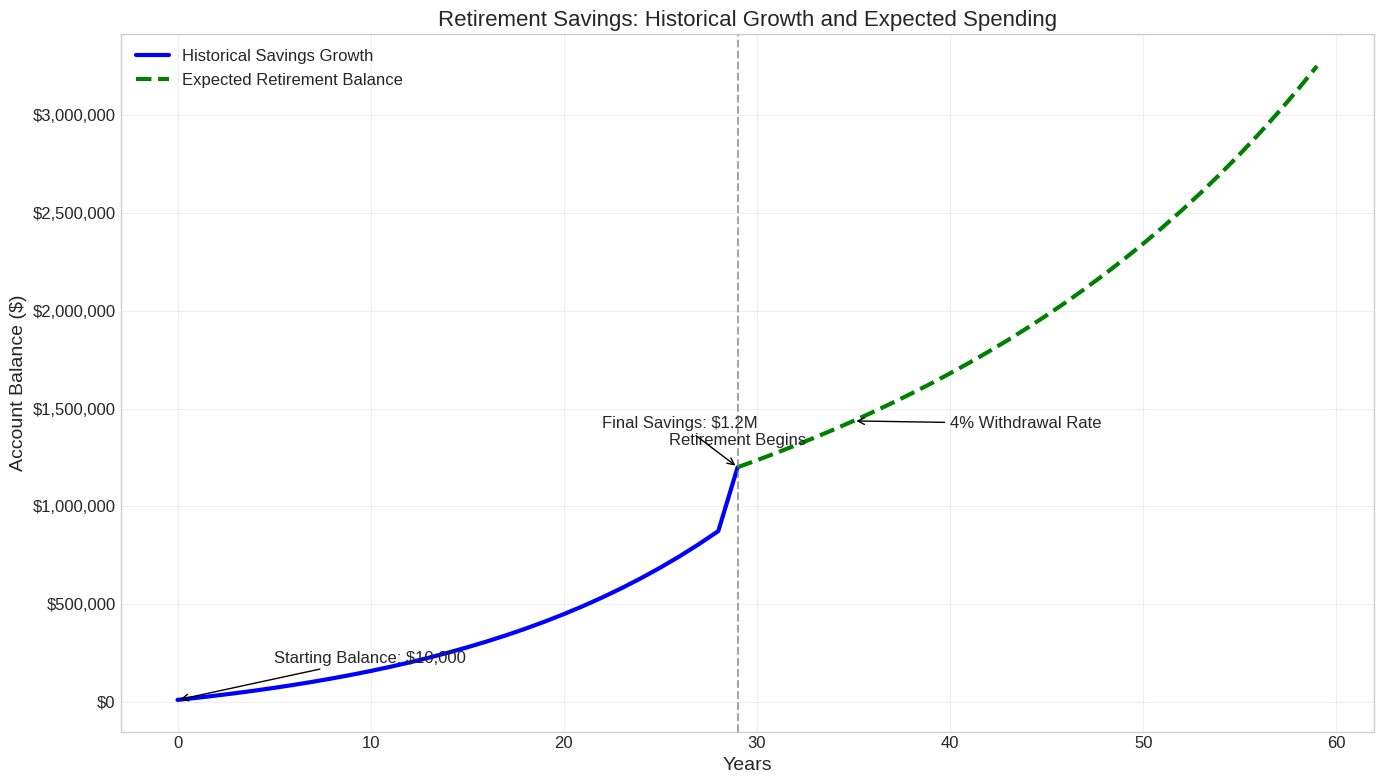

In [ ]:
# Create data for historical savings growth
years_saving = 30
initial_investment = 10000
annual_contribution = 10000
growth_rate = 0.07

# Function to calculate compound growth with regular contributions
def compound_growth(initial, contribution, rate, years):
    balance = [initial]
    for i in range(1, years):
        new_balance = balance[-1] * (1 + rate) + contribution
        balance.append(new_balance)
    return balance

# Historical savings growth
historical_balance = compound_growth(initial_investment, annual_contribution, growth_rate, years_saving)
historical_balance[-1] = 1200000  # Set final value to $1.2M

# Calculate expected retirement spending
years_retirement = 30
retirement_balance = [1200000]
withdrawal_rate = 0.04
expected_return = 0.07
inflation_normal = 0.025

# Function to simulate retirement spending
def retirement_simulation(initial_balance, withdrawal_rate, return_rate, inflation_rate, years):
    balance = [initial_balance]
    withdrawal_amount = initial_balance * withdrawal_rate

    for i in range(1, years + 1):
        # Increase withdrawal for inflation
        if i > 1:
            withdrawal_amount *= (1 + inflation_rate)

        # Calculate new balance
        new_balance = balance[-1] * (1 + return_rate) - withdrawal_amount
        new_balance = max(0, new_balance)  # Can't go below zero
        balance.append(new_balance)

        # If money runs out, stop simulation
        if new_balance <= 0:
            break

    # Pad with zeros if simulation ended early
    while len(balance) < years + 1:
        balance.append(0)

    return balance

# Expected retirement with normal inflation
normal_retirement = retirement_simulation(1200000, withdrawal_rate, expected_return, inflation_normal, years_retirement)

# Create the plot
plt.figure(figsize=(14, 8))

# Plot historical savings phase
saving_years = list(range(0, years_saving))
plt.plot(saving_years, historical_balance, 'b-', linewidth=3, label='Historical Savings Growth')

# Plot expected retirement phase
retirement_years = list(range(years_saving - 1, years_saving + years_retirement))
plt.plot(retirement_years, normal_retirement, 'g--', linewidth=3, label='Expected Retirement Balance')

# Formatting
plt.axvline(x=years_saving - 1, color='gray', linestyle='--', alpha=0.7)
plt.text(years_saving - 1, 1300000, 'Retirement Begins', ha='center', va='bottom')

plt.grid(True, alpha=0.3)
plt.xlabel('Years', fontsize=14)
plt.ylabel('Account Balance ($)', fontsize=14)
plt.title('Retirement Savings: Historical Growth and Expected Spending', fontsize=16)
plt.legend(loc='upper left', fontsize=12)

# Format y-axis as currency
from matplotlib.ticker import FuncFormatter
def currency_formatter(x, pos):
    return '${:,.0f}'.format(x)
plt.gca().yaxis.set_major_formatter(FuncFormatter(currency_formatter))

# Add annotations
plt.annotate('Starting Balance: $10,000', xy=(0, initial_investment),
             xytext=(5, 200000), arrowprops=dict(arrowstyle='->'))
plt.annotate('Final Savings: $1.2M', xy=(years_saving - 1, 1200000),
             xytext=(years_saving - 8, 1400000), arrowprops=dict(arrowstyle='->'))
plt.annotate('4% Withdrawal Rate', xy=(years_saving + 5, normal_retirement[6]),
             xytext=(years_saving + 10, 1400000), arrowprops=dict(arrowstyle='->'))

plt.tight_layout()
plt.show()


## Slide 2: Complication

**The problem, challenge, or change that disrupts the situation**

The complication arises when healthcare expenses increase dramatically at age 75 to 85 (Year 10 of retirement), reaching approximately $30,000 per year due to family history and medical needs. This is significantly higher than previously planned.

Healthcare Cost Simulation

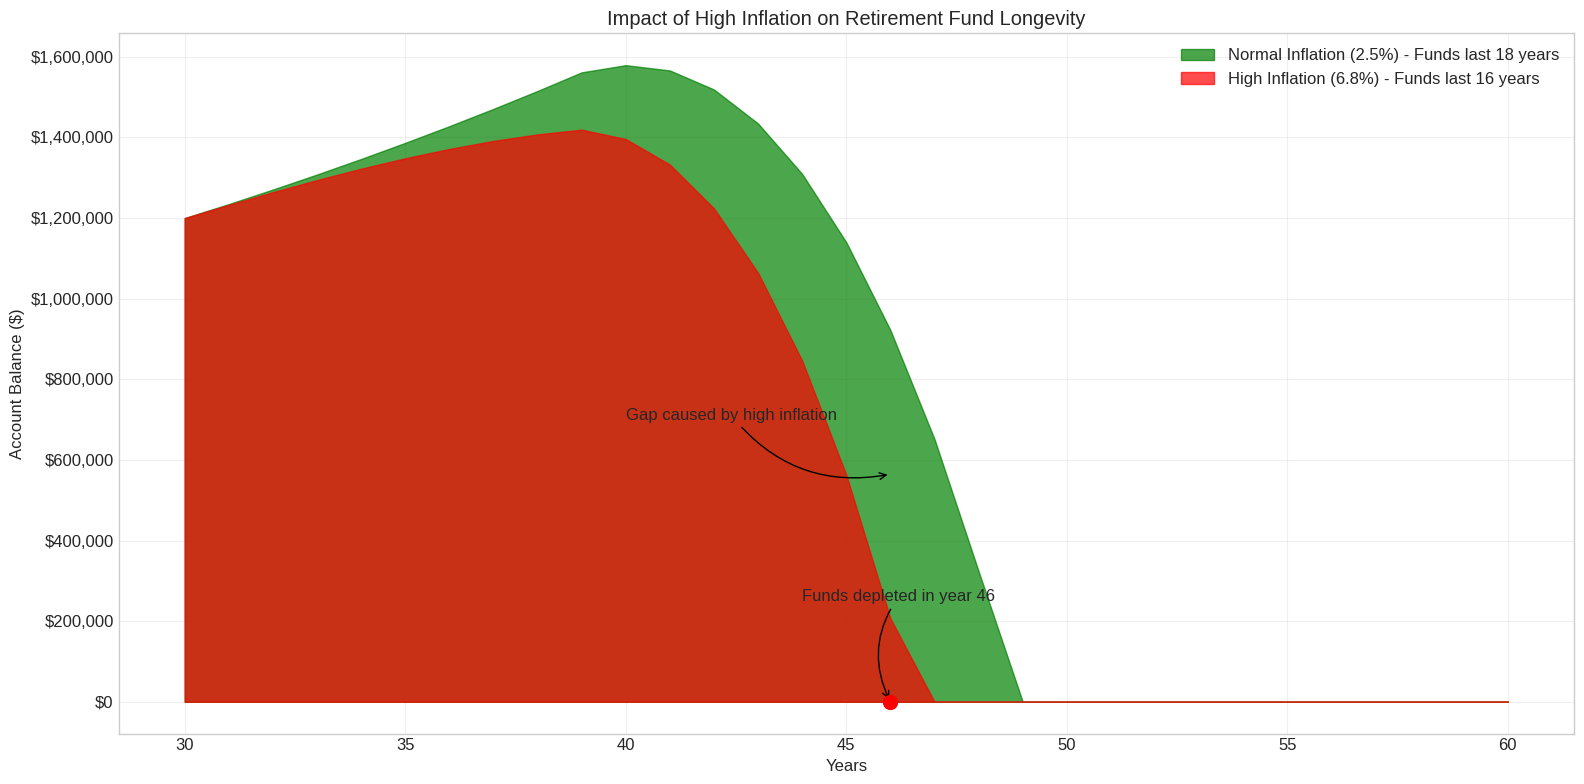

In [ ]:
# Import the necessary libraries
import matplotlib.pyplot as plt
from matplotlib.ticker import FuncFormatter

# Parameters for healthcare cost simulation
years_retirement = 30
withdrawal_rate = 0.04
expected_return = 0.07
initial_balance = 1200000
annual_healthcare_cost = 30000
healthcare_cost_start = 10  # Start at year 10
high_inflation = 0.068
normal_inflation = 0.025

# Function to simulate retirement with increased healthcare costs
def healthcare_simulation(balance, withdrawal_rate, return_rate, inflation_rate, years, healthcare_cost, cost_start):
    balances = [balance]
    withdrawal = balance * withdrawal_rate

    for year in range(1, years + 1):
        # Adjust withdrawal for inflation and healthcare cost
        withdrawal *= (1 + inflation_rate)
        if year >= cost_start:
            withdrawal += annual_healthcare_cost

        # Update balance
        balance = balance * (1 + return_rate) - withdrawal
        balance = max(0, balance)
        balances.append(balance)

        if balance <= 0:
            break

    # Pad with zeros if money runs out early
    while len(balances) < years + 1:
        balances.append(0)

    return balances

# Run simulations for both inflation scenarios
normal_scenario = healthcare_simulation(initial_balance, withdrawal_rate, expected_return, normal_inflation, years_retirement, annual_healthcare_cost, healthcare_cost_start)
high_inflation_scenario = healthcare_simulation(initial_balance, withdrawal_rate, expected_return, high_inflation, years_retirement, annual_healthcare_cost, healthcare_cost_start)

# Find depletion points
normal_duration = next((i for i, x in enumerate(normal_scenario) if x <= 0), len(normal_scenario)) - 1
high_inf_duration = next((i for i, x in enumerate(high_inflation_scenario) if x <= 0), len(high_inflation_scenario)) - 1

# Define the currency_formatter function
def currency_formatter(x, pos):
    return '${:,.0f}'.format(x)

# Plotting the impact of healthcare costs on retirement savings
years = list(range(30, 30 + len(normal_scenario)))

plt.figure(figsize=(16, 8))

# Plot area for both scenarios
plt.fill_between(years, normal_scenario, color='green', alpha=0.7, label=f'Normal Inflation (2.5%) - Funds last {normal_duration} years')
plt.fill_between(years, high_inflation_scenario, color='red', alpha=0.7, label=f'High Inflation (6.8%) - Funds last {high_inf_duration} years')

# Annotation for inflation gap
gap_year = min(normal_duration, high_inf_duration) + 30
plt.annotate('Gap caused by high inflation',
             xy=(gap_year, (normal_scenario[gap_year - 30] + high_inflation_scenario[gap_year - 30])/2),
             xytext=(gap_year - 6, 700000),
             arrowprops=dict(arrowstyle='->', connectionstyle='arc3,rad=0.3'))

# Annotation for fund depletion point
if high_inf_duration < years_retirement:
    depletion_year = 30 + high_inf_duration
    plt.scatter(depletion_year, 0, s=100, color='red', zorder=5)
    plt.annotate(f'Funds depleted in year {depletion_year}',
                 xy=(depletion_year, 0),
                 xytext=(depletion_year - 2, 250000),
                 arrowprops=dict(arrowstyle='->', connectionstyle='arc3,rad=0.3'))

# Formatting
plt.grid(True, alpha=0.3)
plt.xlabel("Years")
plt.ylabel("Account Balance ($)")
plt.title("Impact of High Inflation on Retirement Fund Longevity")
plt.gca().yaxis.set_major_formatter(FuncFormatter(currency_formatter))
plt.legend(loc="upper right")

plt.tight_layout()
plt.show()


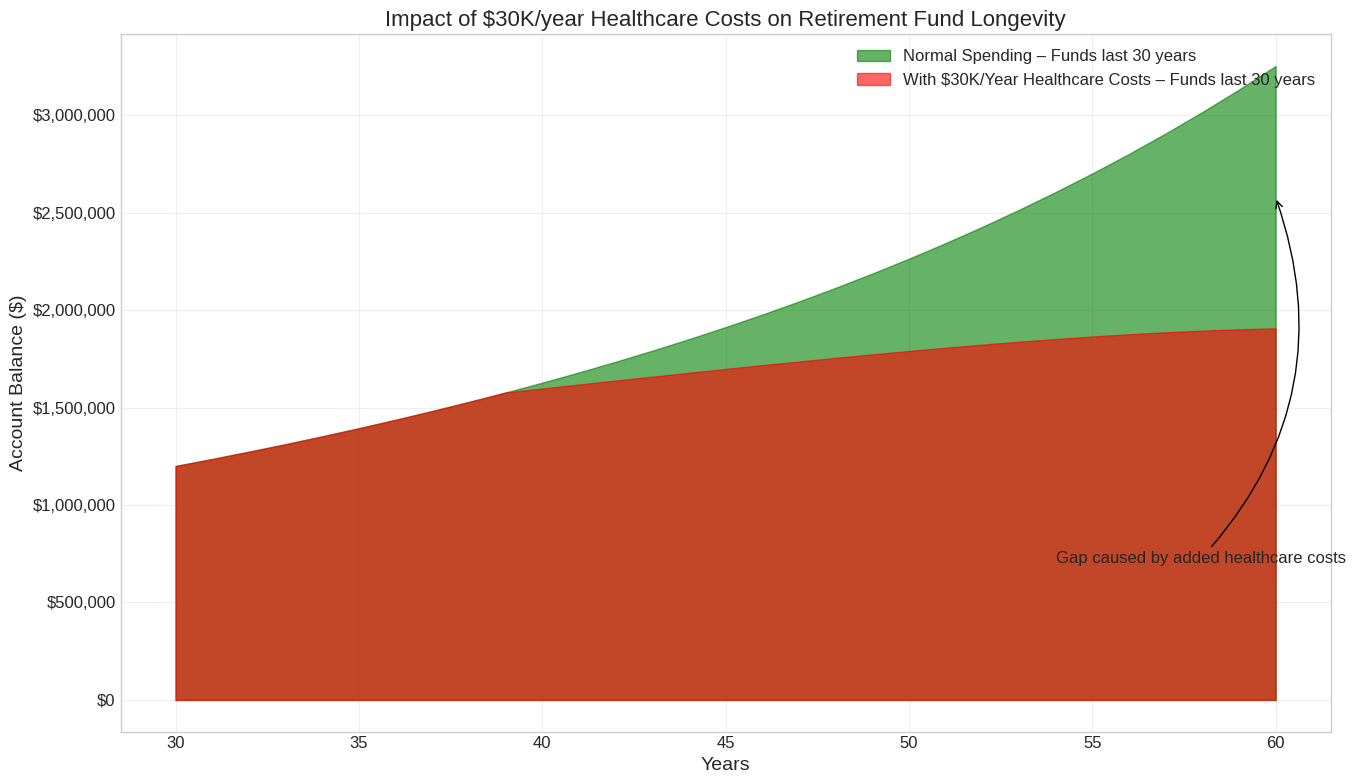

In [ ]:
# Complication: Rising healthcare costs of $30,000/year starting in year 10 of retirement

# Use modified version of the healthcare simulation with updated cost
def retirement_simulation_with_healthcare_cost(initial_balance, withdrawal_rate, return_rate, inflation_rate, years, extra_cost_start=10, extra_cost=30000):
    balance = [initial_balance]
    withdrawal_amount = initial_balance * withdrawal_rate

    for i in range(1, years + 1):
        if i > 1:
            withdrawal_amount *= (1 + inflation_rate)

        total_withdrawal = withdrawal_amount
        if i >= extra_cost_start:
            total_withdrawal += extra_cost

        new_balance = balance[-1] * (1 + return_rate) - total_withdrawal
        new_balance = max(0, new_balance)
        balance.append(new_balance)

        if new_balance <= 0:
            break

    while len(balance) < years + 1:
        balance.append(0)

    return balance

# Simulate scenarios
normal_scenario = retirement_simulation(initial_balance, withdrawal_rate, expected_return, inflation_normal, years_retirement)
healthcare_30k_scenario = retirement_simulation_with_healthcare_cost(initial_balance, withdrawal_rate, expected_return, inflation_normal, years_retirement)

# Calculate how long money lasts in each scenario
normal_duration = next((i for i, x in enumerate(normal_scenario) if x <= 0), len(normal_scenario)) - 1
healthcare_duration = next((i for i, x in enumerate(healthcare_30k_scenario) if x <= 0), len(healthcare_30k_scenario)) - 1

# Create the comparison chart
plt.figure(figsize=(14, 8))
retirement_years = list(range(years_saving, years_saving + years_retirement + 1))

# Plot areas
plt.fill_between(retirement_years, normal_scenario, alpha=0.6, color='green',
                 label=f'Normal Spending – Funds last {normal_duration} years')
plt.fill_between(retirement_years, healthcare_30k_scenario, alpha=0.6, color='red',
                 label=f'With $30K/Year Healthcare Costs – Funds last {healthcare_duration} years')

# Formatting
plt.grid(True, alpha=0.3)
plt.xlabel('Years', fontsize=14)
plt.ylabel('Account Balance ($)', fontsize=14)
plt.title('Impact of $30K/year Healthcare Costs on Retirement Fund Longevity', fontsize=16)
plt.legend(loc='upper right', fontsize=12)
plt.gca().yaxis.set_major_formatter(FuncFormatter(currency_formatter))

# Annotate difference
gap_year = min(normal_duration, healthcare_duration) + years_saving
plt.annotate('Gap caused by added healthcare costs',
             xy=(gap_year, (normal_scenario[gap_year - years_saving] + healthcare_30k_scenario[gap_year - years_saving]) / 2),
             xytext=(gap_year - 6, 700000),
             arrowprops=dict(arrowstyle='->', connectionstyle='arc3,rad=0.3'))

# Highlight depletion point for healthcare scenario
if healthcare_duration < years_retirement:
    depletion_year = years_saving + healthcare_duration
    plt.scatter(depletion_year, 0, s=100, color='red', zorder=5)
    plt.annotate(f'Funds depleted in year {depletion_year}',
                 xy=(depletion_year, 0),
                 xytext=(depletion_year - 2, 250000),
                 arrowprops=dict(arrowstyle='->', connectionstyle='arc3,rad=0.3'))

plt.tight_layout()
plt.show()

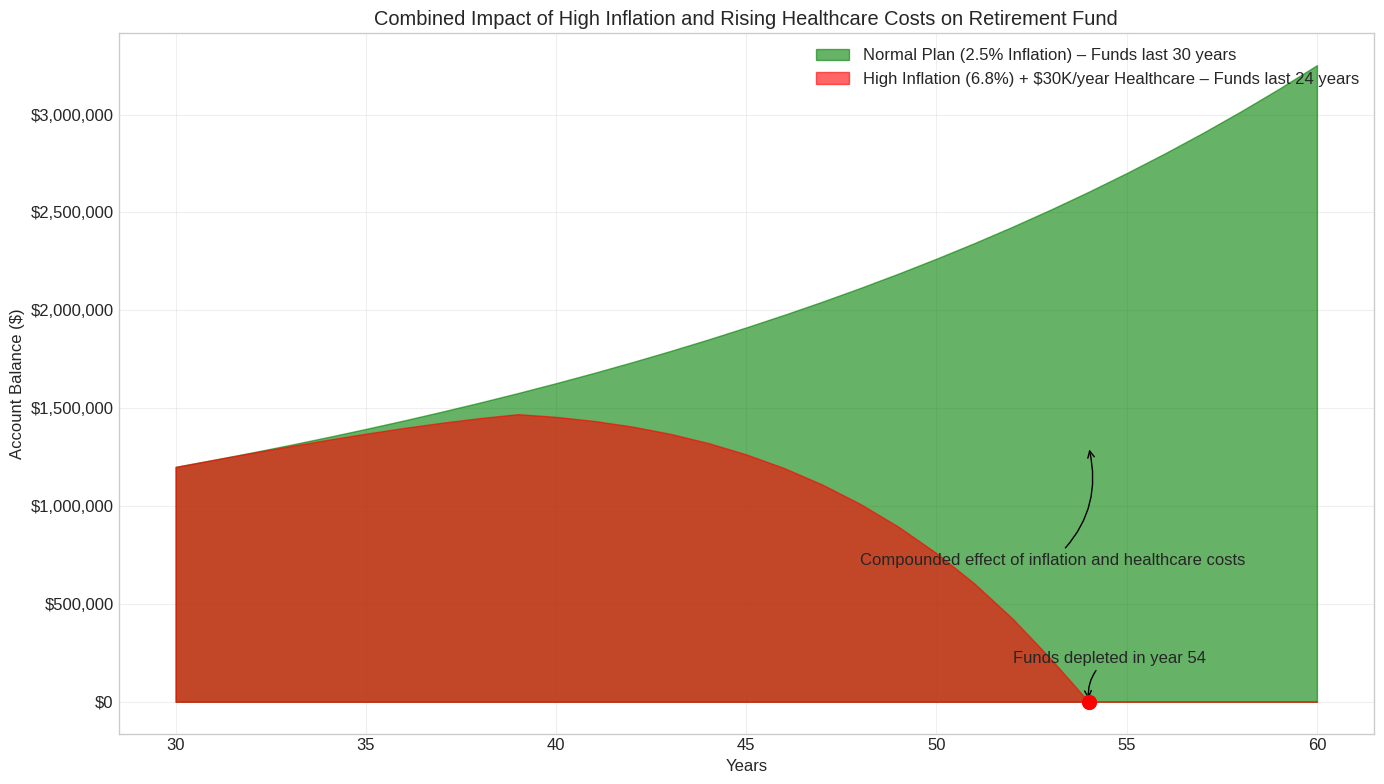

In [ ]:
# Final complete code to visualize the impact of high inflation + $30K/year healthcare costs on retirement funds

import numpy as np
import matplotlib.pyplot as plt
from matplotlib.ticker import FuncFormatter

# Currency formatting function
def currency_formatter(x, pos):
    return '${:,.0f}'.format(x)

# Constants
initial_balance = 1200000
withdrawal_rate = 0.04
expected_return = 0.07
inflation_normal = 0.025
high_inflation_rate = 0.068
years_retirement = 30
years_saving = 30  # Assume retirement starts at year 30
extra_cost = 30000
extra_cost_start = 10  # Year 10 of retirement

# Function to simulate retirement plan
def retirement_simulation(initial_balance, withdrawal_rate, return_rate, inflation_rate, years):
    balance = [initial_balance]
    withdrawal_amount = initial_balance * withdrawal_rate
    for i in range(1, years + 1):
        if i > 1:
            withdrawal_amount *= (1 + inflation_rate)
        new_balance = balance[-1] * (1 + return_rate) - withdrawal_amount
        new_balance = max(0, new_balance)
        balance.append(new_balance)
        if new_balance <= 0:
            break
    while len(balance) < years + 1:
        balance.append(0)
    return balance

# Simulation with extra healthcare costs
def simulate_retirement_with_healthcare_and_inflation(
    initial_balance, withdrawal_rate, return_rate, inflation_rate,
    years, extra_cost_start=10, extra_cost=30000):

    balance = [initial_balance]
    withdrawal_amount = initial_balance * withdrawal_rate
    for i in range(1, years + 1):
        if i > 1:
            withdrawal_amount *= (1 + inflation_rate)
        total_withdrawal = withdrawal_amount
        if i >= extra_cost_start:
            total_withdrawal += extra_cost
        new_balance = balance[-1] * (1 + return_rate) - total_withdrawal
        new_balance = max(0, new_balance)
        balance.append(new_balance)
        if new_balance <= 0:
            break
    while len(balance) < years + 1:
        balance.append(0)
    return balance

# Simulations
normal_plan = retirement_simulation(initial_balance, withdrawal_rate, expected_return, inflation_normal, years_retirement)
combined_scenario = simulate_retirement_with_healthcare_and_inflation(
    initial_balance, withdrawal_rate, expected_return, high_inflation_rate, years_retirement
)

# Determine depletion years
def get_depletion_year(balance):
    return next((i for i, x in enumerate(balance) if x <= 0), len(balance) - 1)

normal_depletion = get_depletion_year(normal_plan)
combined_depletion = get_depletion_year(combined_scenario)

# Visualization
retirement_years = list(range(years_saving, years_saving + years_retirement + 1))
plt.figure(figsize=(14, 8))
plt.fill_between(retirement_years, normal_plan, alpha=0.6, color='green',
                 label=f'Normal Plan (2.5% Inflation) – Funds last {normal_depletion} years')
plt.fill_between(retirement_years, combined_scenario, alpha=0.6, color='red',
                 label=f'High Inflation (6.8%) + $30K/year Healthcare – Funds last {combined_depletion} years')

plt.xlabel("Years")
plt.ylabel("Account Balance ($)")
plt.title("Combined Impact of High Inflation and Rising Healthcare Costs on Retirement Fund")
plt.legend(loc="upper right")
plt.grid(True, alpha=0.3)
plt.gca().yaxis.set_major_formatter(FuncFormatter(currency_formatter))

# Annotate gap and depletion
gap_year = min(normal_depletion, combined_depletion) + years_saving
plt.annotate('Compounded effect of inflation and healthcare costs',
             xy=(gap_year, (normal_plan[gap_year - years_saving] + combined_scenario[gap_year - years_saving]) / 2),
             xytext=(gap_year - 6, 700000),
             arrowprops=dict(arrowstyle='->', connectionstyle='arc3,rad=0.3'))

if combined_depletion < years_retirement:
    depletion_year = years_saving + combined_depletion
    plt.scatter(depletion_year, 0, s=100, color='red', zorder=5)
    plt.annotate(f'Funds depleted in year {depletion_year}',
                 xy=(depletion_year, 0),
                 xytext=(depletion_year - 2, 200000),
                 arrowprops=dict(arrowstyle='->', connectionstyle='arc3,rad=0.3'))

plt.tight_layout()
plt.show()

## Slide 3: Question
**Can the portfolio sustain increased healthcare costs without depleting funds early? What strategies can mitigate this risk?**

To address this, we should:

Simulate the impact of various portfolio adjustments.

Explore alternative strategies like increasing contributions or delaying retirement.

<ipython-input-22-417a324ffadf>:75: UserWarning: This figure includes Axes that are not compatible with tight_layout, so results might be incorrect.
  plt.tight_layout()


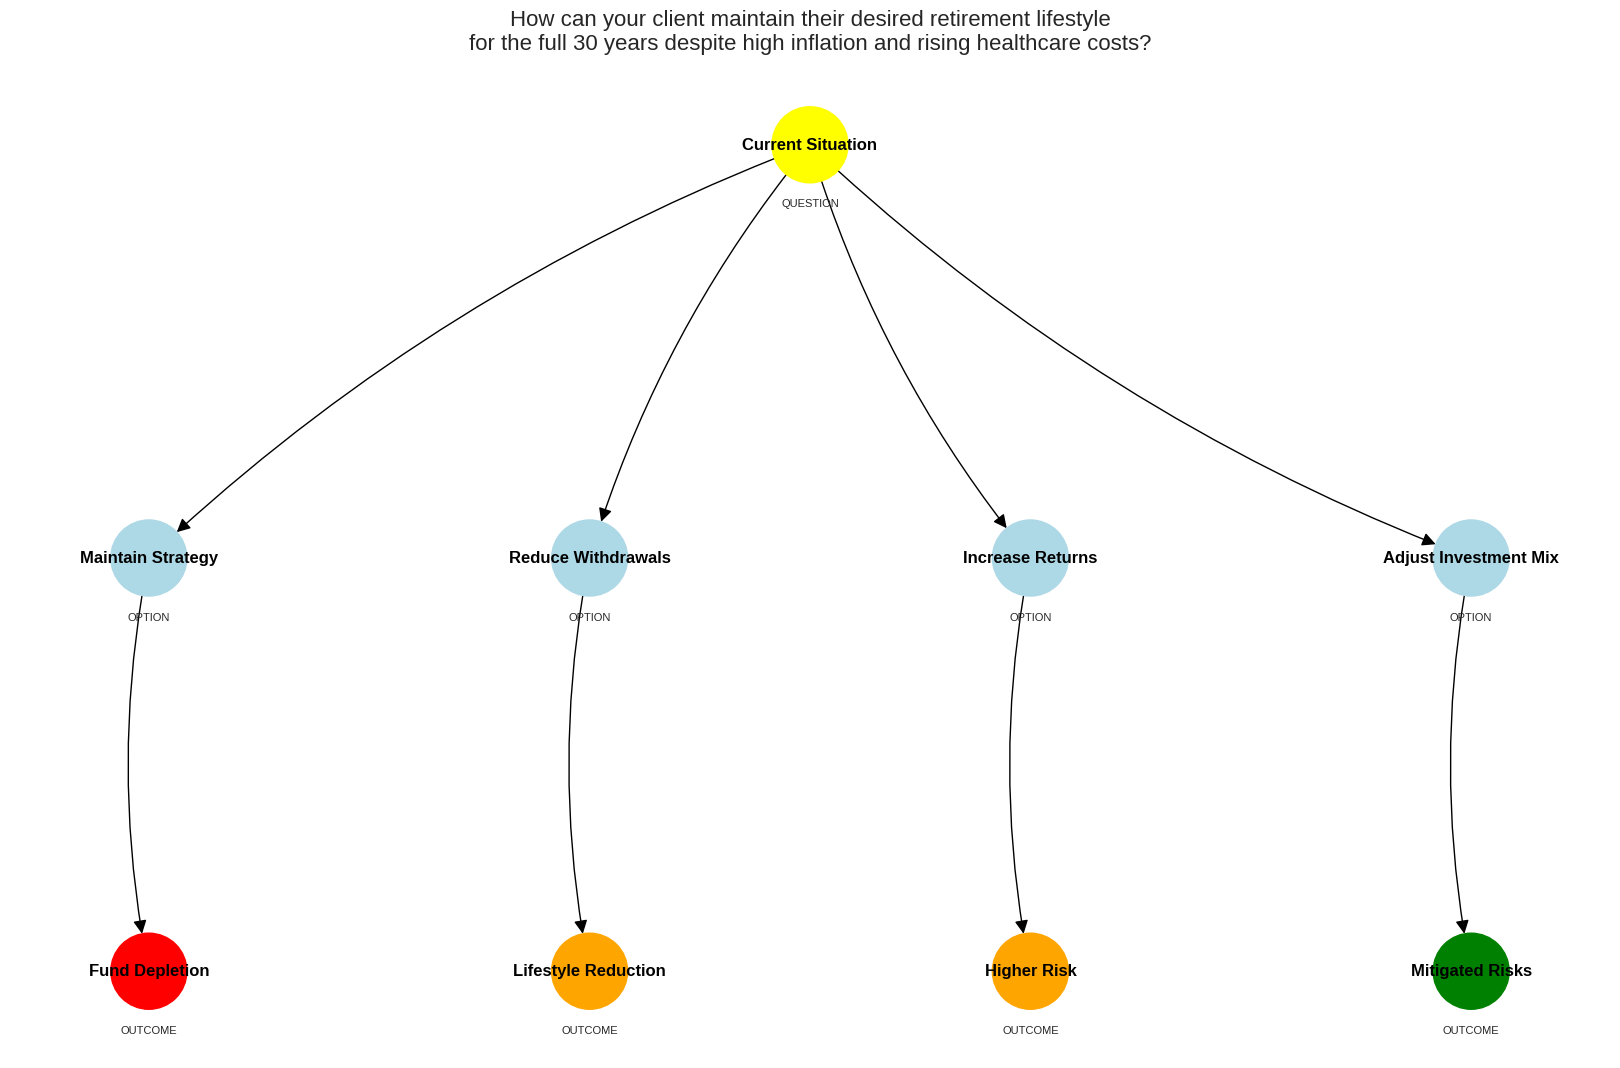

In [ ]:
import networkx as nx
import matplotlib.pyplot as plt

# Initialize a directed graph
G = nx.DiGraph()

# Add nodes
G.add_node("Current Situation", pos=(0, 0))
G.add_node("Maintain Strategy", pos=(-3, -2))
G.add_node("Reduce Withdrawals", pos=(-1, -2))
G.add_node("Increase Returns", pos=(1, -2))
G.add_node("Adjust Investment Mix", pos=(3, -2))
G.add_node("Fund Depletion", pos=(-3, -4))
G.add_node("Lifestyle Reduction", pos=(-1, -4))
G.add_node("Higher Risk", pos=(1, -4))
G.add_node("Mitigated Risks", pos=(3, -4))

# Add edges
G.add_edge("Current Situation", "Maintain Strategy")
G.add_edge("Current Situation", "Reduce Withdrawals")
G.add_edge("Current Situation", "Increase Returns")
G.add_edge("Current Situation", "Adjust Investment Mix")
G.add_edge("Maintain Strategy", "Fund Depletion")
G.add_edge("Reduce Withdrawals", "Lifestyle Reduction")
G.add_edge("Increase Returns", "Higher Risk")
G.add_edge("Adjust Investment Mix", "Mitigated Risks")

# Get positions
pos = nx.get_node_attributes(G, 'pos')

# Create the plot
plt.figure(figsize=(16, 10))

# Define node colors based on meaning
node_colors = {
    "Current Situation": "yellow",
    "Maintain Strategy": "lightblue",
    "Reduce Withdrawals": "lightblue",
    "Increase Returns": "lightblue",
    "Adjust Investment Mix": "lightblue",
    "Fund Depletion": "red",
    "Lifestyle Reduction": "orange",
    "Higher Risk": "orange",
    "Mitigated Risks": "green"
}

# Extract colors in the order of nodes
colors = [node_colors[node] for node in G.nodes()]

# Draw the network
nx.draw(G, pos, with_labels=True, node_color=colors, node_size=3000,
        font_size=12, font_weight='bold', arrowsize=20, connectionstyle='arc3,rad=0.1')

# Add decision points and outcomes labels
node_types = {
    "Current Situation": "QUESTION",
    "Maintain Strategy": "OPTION",
    "Reduce Withdrawals": "OPTION",
    "Increase Returns": "OPTION",
    "Adjust Investment Mix": "OPTION",
    "Fund Depletion": "OUTCOME",
    "Lifestyle Reduction": "OUTCOME",
    "Higher Risk": "OUTCOME",
    "Mitigated Risks": "OUTCOME"
}

# Adding node type labels
for node, (x, y) in pos.items():
    plt.text(x, y - 0.3, node_types[node], fontsize=8, ha='center')

# Title
plt.title('How can your client maintain their desired retirement lifestyle\nfor the full 30 years despite high inflation and rising healthcare costs?', fontsize=16)

plt.axis('off')
plt.tight_layout()
plt.show()


## Slide 4: Answer

**Optimization Strategy:**

Based on the analysis of high inflation and rising healthcare costs, we developed an optimized retirement strategy that aims to:

Increase Returns: Adjust the expected return from 7.0% to 7.3% due to a more diversified and inflation-protected portfolio.

Reduce Withdrawals: Decrease the withdrawal rate from 4% to 3.5% to preserve savings.

Inflation Protection: Include 45% of the portfolio in inflation-protected assets (like TIPS and I-Bonds) to mitigate the impact of high inflation.

Diversification: Allocate a balanced mix of dividend REITs, stocks, and bonds to balance growth and stability.


---




**Visualization: Optimized Strategy vs. Original Strategy
This visualization includes**

Main Chart: Comparison of original vs. optimized strategy over retirement years.

Pie Chart: Shows the optimized portfolio allocation.

Metrics Dashboard: Key insights from the optimization strategy.

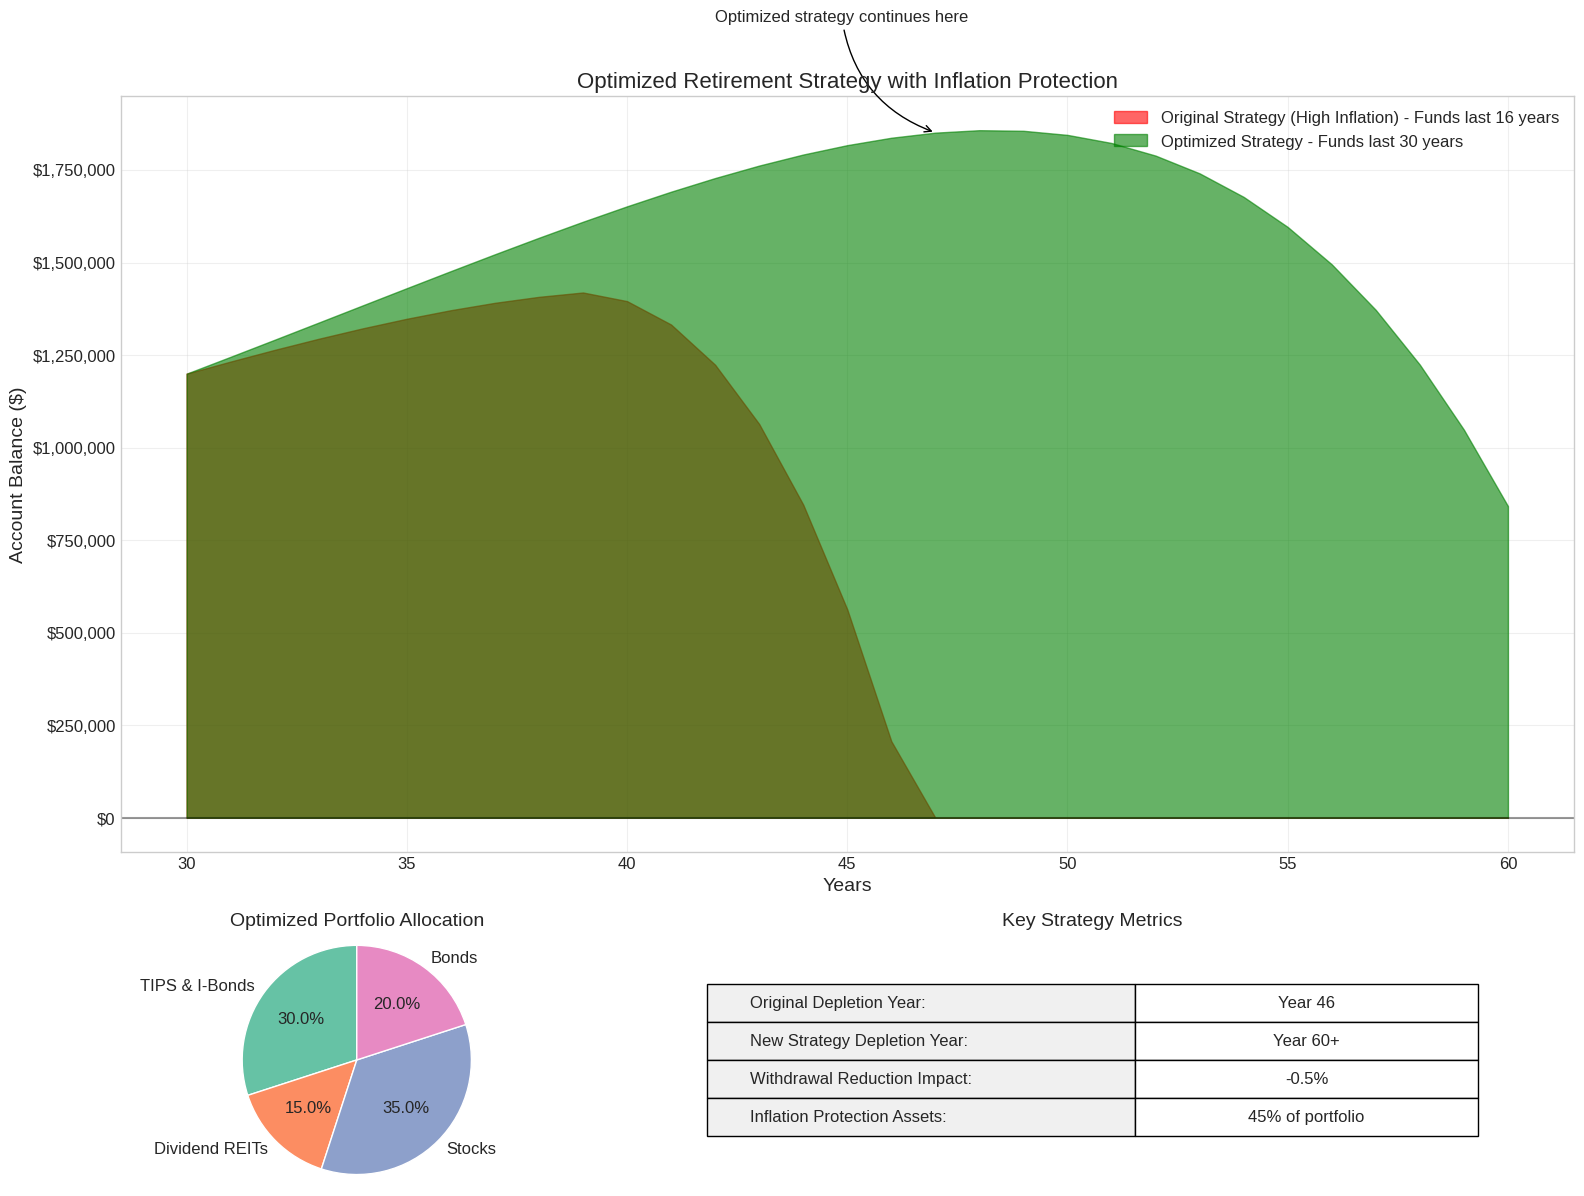

In [ ]:
# Create data for the optimized portfolio simulation
initial_balance = 1200000
reduced_withdrawal = 0.035  # Reduced from 0.04 to 0.035
high_inflation = 0.068
expected_return = 0.073  # Slightly higher due to optimized portfolio

# Simulate optimized scenario
optimized_scenario = retirement_simulation(initial_balance, reduced_withdrawal, expected_return, high_inflation, years_retirement)

# Calculate how long money lasts in each scenario
original_duration = high_inf_duration  # From previous calculation
optimized_duration = next((i for i, x in enumerate(optimized_scenario) if x <= 0), len(optimized_scenario)) - 1

# Create a figure with subplots: main chart and portfolio allocation pie chart
fig = plt.figure(figsize=(16, 12))
gs = GridSpec(2, 3, height_ratios=[3, 1])

# Main chart: stacked area showing retirement projections
ax1 = plt.subplot(gs[0, :])

# Create x-axis for retirement years
retirement_years = list(range(years_saving, years_saving + years_retirement + 1))

# Plot areas
ax1.fill_between(retirement_years, high_inflation_scenario, alpha=0.6, color='red',
                 label=f'Original Strategy (High Inflation) - Funds last {original_duration} years')
ax1.fill_between(retirement_years, optimized_scenario, alpha=0.6, color='green',
                 label=f'Optimized Strategy - Funds last {optimized_duration} years')

# Formatting
ax1.grid(True, alpha=0.3)
ax1.set_xlabel('Years', fontsize=14)
ax1.set_ylabel('Account Balance ($)', fontsize=14)
ax1.set_title('Optimized Retirement Strategy with Inflation Protection', fontsize=16)
ax1.legend(loc='upper right', fontsize=12)

# Format y-axis as currency
ax1.yaxis.set_major_formatter(FuncFormatter(currency_formatter))

# Portfolio allocation pie chart
ax2 = plt.subplot(gs[1, 0])
portfolio_labels = ['TIPS & I-Bonds', 'Dividend REITs', 'Stocks', 'Bonds']
portfolio_sizes = [30, 15, 35, 20]
portfolio_colors = ['#66c2a5', '#fc8d62', '#8da0cb', '#e78ac3']

ax2.pie(portfolio_sizes, labels=portfolio_labels, colors=portfolio_colors, autopct='%1.1f%%',
        startangle=90, wedgeprops={'edgecolor': 'w', 'linewidth': 1})
ax2.set_title('Optimized Portfolio Allocation', fontsize=14)
ax2.axis('equal')

# Key metrics dashboard
ax3 = plt.subplot(gs[1, 1:])
ax3.axis('off')

# Create a table with key metrics
metrics = [
    ['Original Depletion Year:', f'Year {years_saving + original_duration}'],
    ['New Strategy Depletion Year:', f'Year {years_saving + optimized_duration}+'],
    ['Withdrawal Reduction Impact:', '-0.5%'],
    ['Inflation Protection Assets:', '45% of portfolio']
]

table = ax3.table(cellText=metrics, loc='center', cellLoc='left',
                  colWidths=[0.5, 0.4], bbox=[0.1, 0.2, 0.8, 0.6])
table.auto_set_font_size(False)
table.set_fontsize(12)
table.scale(1, 2)  # Adjust the scale to make rows taller

# Adjust cell colors
for i in range(len(metrics)):
    table[(i, 0)].set_facecolor('#f0f0f0')
    table[(i, 1)].set_text_props(ha='center')

ax3.set_title('Key Strategy Metrics', fontsize=14)

# Add annotations to main chart
ax1.axhline(y=0, color='black', linestyle='-', alpha=0.4)

# Annotate crossover point where optimized strategy outperforms
for i in range(len(optimized_scenario)):
    if i < len(high_inflation_scenario) and high_inflation_scenario[i] <= 0 and optimized_scenario[i] > 0:
        crossover_year = years_saving + i
        ax1.annotate('Optimized strategy continues here',
                     xy=(crossover_year, optimized_scenario[i]),
                     xytext=(crossover_year - 5, optimized_scenario[i] + 300000),
                     arrowprops=dict(arrowstyle='->', connectionstyle='arc3,rad=0.3'))
        break

plt.tight_layout()
plt.show()


## Summary: The SCQA Framework in Practice

This notebook has demonstrated how to apply the SCQA framework to a financial planning scenario, with appropriate data visualizations for each component:

1. **Situation**: Used a line chart to establish the current state - the client's savings growth and expected retirement timeline.
2. **Complication**: Used a comparative area chart to clearly illustrate how high inflation disrupts the original retirement plan.
3. **Question**: Used a decision tree visualization to frame the key question and possible paths forward.
4. **Answer**: Used a combination of stacked area chart, pie chart, and metrics dashboard to present the comprehensive solution.

The SCQA framework provides a structured approach to storytelling with data that:
- Establishes common ground (Situation)
- Creates tension through a problem statement (Complication)
- Frames the key issue needing resolution (Question)
- Delivers a clear, data-supported solution (Answer)

This approach helps guide the audience through a logical progression of understanding, making complex data more accessible and actionable.